In [1]:
import os
import csv
import torch
import numpy as np
from torch import nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.ndimage import binary_erosion
from skimage.measure import label, regionprops
from skimage.color import rgb2gray, rgba2rgb
from skimage.morphology import skeletonize
import torch.nn.functional as func
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from models import ConvNeXtTiny, SimpleUNet

def fit_ellipse(mask):
    points = np.where(skeletonize(mask))    
    # Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0
    best_a = 0.5 * (np.max(points[1]).astype(np.float32) - np.min(points[1]).astype(np.float32))
    best_b = 0.5 * (np.max(points[0]).astype(np.float32) - np.min(points[0]).astype(np.float32))
    best_x0 = np.mean(points[1]).astype(np.float32)
    best_y0 = np.mean(points[0]).astype(np.float32)
    best_theta = 0.
    best_fit = np.inf
    best_i = 0
    n_iter = 100
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    a = torch.tensor(best_a, device=device, requires_grad=True)
    b = torch.tensor(best_b, device=device, requires_grad=True)
    x0 = torch.tensor(best_x0, device=device, requires_grad=True)
    y0 = torch.tensor(best_y0, device=device, requires_grad=True)
    theta = torch.tensor(best_theta, device=device, requires_grad=True)

    x = torch.from_numpy(points[1]).to(device)
    y = torch.from_numpy(points[0]).to(device)

    optimizer = torch.optim.Adam([a, b, theta], lr=1)
    for i in range(n_iter):
        new_theta = torch.clamp(theta, - np.pi / 2, np.pi / 2)
        A = a ** 2 * torch.sin(new_theta) ** 2 + b ** 2 * torch.cos(new_theta) ** 2
        B = 2 * (b ** 2 - a ** 2) * torch.sin(new_theta) * torch.cos(new_theta) ** 2
        C = a ** 2 * torch.cos(new_theta) ** 2 + b ** 2 * torch.sin(new_theta) ** 2
        D = -2 * A * x0 - B * y0
        E = -2 * C * y0 - B * x0
        F = A * x0 ** 2 + B * x0 * y0 + C * y0 ** 2 - a ** 2 * b ** 2
        loss = torch.norm(
            A * x * x + B * x * y + C * y * y + D * x + E * y + F
        )
        loss_value = loss.detach().cpu().numpy().tolist()
        if loss_value < best_fit:
            best_fit = loss_value
            best_a = a.detach().cpu().numpy().tolist()
            best_b = b.detach().cpu().numpy().tolist()
            best_x0 = x0.detach().cpu().numpy().tolist()
            best_y0 = y0.detach().cpu().numpy().tolist()
            best_theta = new_theta.detach().cpu().numpy().tolist()
            best_i = i
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return best_a, best_b, best_x0, best_y0, best_theta


def ellipse_to_mask(a, b, theta, x0, y0, height, width):
    # Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0
    A = a ** 2 * np.sin(theta) ** 2 + b ** 2 * np.cos(theta) ** 2
    B = 2 * (b ** 2 - a ** 2) * np.sin(theta) * np.cos(theta) ** 2
    C = a ** 2 * np.cos(theta) ** 2 + b ** 2 * np.sin(theta) ** 2
    D = -2 * A * x0 - B * y0
    E = -2 * C * y0 - B * x0
    F = A * x0 ** 2 + B * x0 * y0 + C * y0 ** 2 - a ** 2 * b ** 2
    
    x, y = np.meshgrid(range(width), range(height))
    values = A * x * x + B * x * y + C * y * y + D * x + E * y + F
    return values

In [ ]:
points_path = 'Sample/Clandmarks.png'
image_path = 'Sample/Cim.png'
points_im = imread(points_path)
rgb_im = rgba2rgb(points_im)
im = rgb2gray(rgb_im)
rgb_points = rgba2rgb(points_im)
points = rgb_points[points_im[..., -1] == 1, :]
regions = np.unique(points, axis=0)
for region in regions:
    region_mask = np.prod(
        rgb_im == region.reshape(1, 3), axis=-1
    ).astype(bool)
    label_img = label(region_mask)
    region_props = regionprops(label_img)
    centroids = [prop.centroid for prop in region_props]
    print(region * 255, centroids)

In [ ]:
training_path = 'training_set/'
csv_name = 'parameters.csv'
im_suffix = 'HC.png'
if not os.path.exists(training_path):
    !wget -O training_set.zip https://zenodo.org/record/1327317/files/training_set.zip?download=1
    !unzip training_set.zip && rm training_set.zip

subjects = sorted([
    f for f in os.listdir(training_path)
    if f.endswith(im_suffix)
])
fig = plt.figure()
params = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for im_name in subjects:
    subject = im_name.split('.')[0]
    label_name = '{:}_Annotation.png'.format(subject) 

    im_path = os.path.join(training_path, im_name)
    im = imread(im_path)
    label_path = os.path.join(training_path, label_name)
    labels = imread(label_path)
    best_a, best_b, best_x0, best_y0, best_theta = fit_ellipse(labels > 0)

    print('Best', subject, best_a, best_b, best_x0, best_y0, best_theta)
    n_points = 1000
    angles = (np.arange(n_points) / n_points) * 2 * np.pi
    ideal_x = best_a * np.cos(angles)
    ideal_y = best_b * np.sin(angles)

    new_x = ideal_x * np.cos(best_theta) - ideal_y * np.sin(best_theta) + best_x0
    new_y = ideal_y * np.cos(best_theta) + ideal_x * np.sin(best_theta) + best_y0

    plt.scatter(new_x, new_y, s=1, c='g')
    plt.scatter(best_x0, best_y0, s=1, c='g')
    
    params.append([subject, best_a, best_b, best_x0, best_y0, best_theta])

with open(
        os.path.join(training_path, csv_name), 'w'
) as csvfile:
    evalwriter = csv.writer(csvfile)
    for param in params:
        evalwriter.writerow(param)

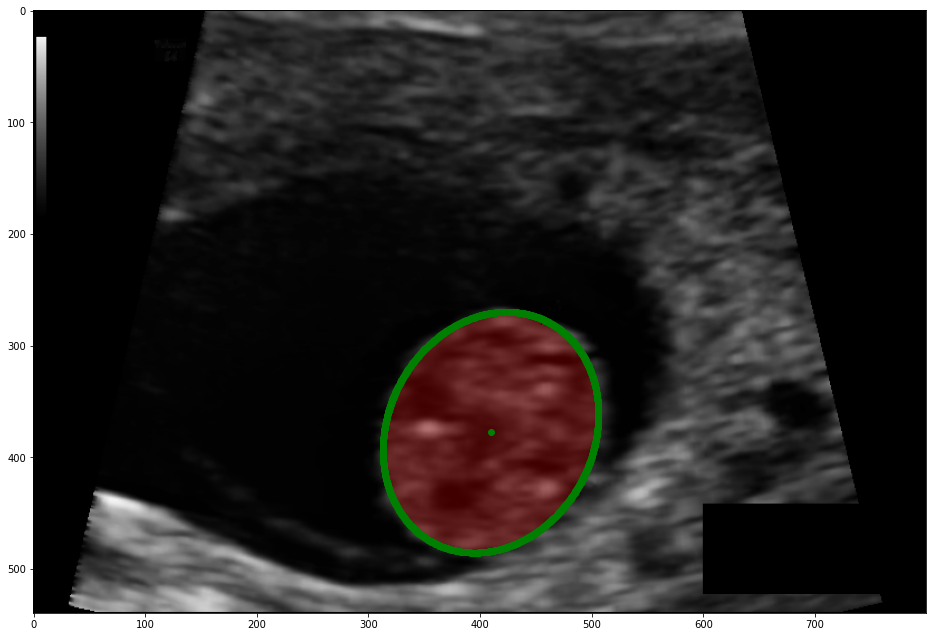

In [32]:
training_path = 'training_set/'
testing_path = 'testing_set/'
csv_name = 'parameters.csv'
im_suffix = 'HC.png'

height = 540
width = 800
im_size = (height, width)
half_x = im_size[1] / 2
half_y = im_size[0] / 2
angles = (np.arange(n_points) / n_points) * 2 * np.pi

fig = plt.figure(figsize=(16, 42))

class SkullUSDataset(Dataset):
    def __init__(
        self, data_path, csv_file, label_suffix='_Annotation.png',
        sub_list=None, im_size=None
    ):
        if im_size is None:
            self.im_size = (540, 800)
        else:
            self.im_size = im_size
        half_x = self.im_size[1] / 2
        half_y = self.im_size[0] / 2
        csv_path = os.path.join(data_path, csv_file)
        self.data = []
        self.labels = []
        self.params = []
        with open(csv_path, 'r') as csvfile:
            evalreader = csv.reader(csvfile)
            for subject, a, b, x0, y0, theta in evalreader:
                im_name = '{:}.png'.format(subject)
                if sub_list is None or im_name in sub_list:
                    im_path = os.path.join(
                        data_path, im_name
                    )
                    im = imread(im_path)
                    if im.shape == self.im_size:
                        self.data.append(imread(im_path))
                        label_name = subject + label_suffix
                        label_path = os.path.join(data_path, label_name)
                        self.labels.append(imread(label_path))
                        self.params.append(np.array([a, b, x0, y0, theta]))

    def __getitem__(self, index):
        image = self.data[index]
        data = np.repeat(
            np.expand_dims(image, 0), 3, axis=0
        ).astype(np.float32)
        labels = np.expand_dims(self.labels[index].astype(np.uint8), axis=0)
        params = self.params[index].astype(np.float32)

        return data, (labels, params)

    def __len__(self):
        return len(self.data)

# for im, (_, (norm_a, norm_b, norm_x0, norm_y0, true_theta)) in SkullUSDataset(training_path, csv_name)[0]:
im, (_, (true_a, true_b, true_x0, true_y0, true_theta)) = SkullUSDataset(training_path, csv_name)[0]

segmentation = ellipse_to_mask(
    true_a, true_b, true_theta, true_x0, true_y0,
    height, width
)

ideal_x = true_a * np.cos(angles)
ideal_y = true_b * np.sin(angles)
new_x = ideal_x * np.cos(true_theta) - ideal_y * np.sin(true_theta) + true_x0
new_y = ideal_y * np.cos(true_theta) + ideal_x * np.sin(true_theta) + true_y0

im_trans = np.concatenate([im, 1 - np.expand_dims(segmentation < 0, axis=0) * 0.5])

fig.clear()
plt.imshow(segmentation < 0, cmap='jet')
plt.imshow(np.moveaxis(im_trans, 0, 2), cmap='gray')
plt.scatter(new_x, new_y, c='g')
plt.scatter(true_x0, true_y0, c='g')

In [ ]:
training_path = 'training_set/'
testing_path = 'testing_set/'
csv_name = 'parameters.csv'
im_suffix = 'HC.png'
n_folds = 5
val_split = 0.1
train_size = 8
test_size = 8
epochs = 30
patience = 10
subjects = sorted([
    f for f in os.listdir(training_path)
    if f.endswith(im_suffix)
])

im_size = (540, 800)
half_x = im_size[1] / 2
half_y = im_size[0] / 2

n_points = 1000
angles = (np.arange(n_points) / n_points) * 2 * np.pi

class SkullUSDataset(Dataset):
    def __init__(
        self, data_path, csv_file, label_suffix='_Annotation.png',
        sub_list=None, im_size=None
    ):
        if im_size is None:
            self.im_size = (540, 800)
        else:
            self.im_size = im_size
        half_x = self.im_size[1] / 2
        half_y = self.im_size[0] / 2
        csv_path = os.path.join(data_path, csv_file)
        self.data = []
        self.labels = []
        self.params = []
        with open(csv_path, 'r') as csvfile:
            evalreader = csv.reader(csvfile)
            for subject, a, b, x0, y0, theta in evalreader:
                im_name = '{:}.png'.format(subject)
                if sub_list is None or im_name in sub_list:
                    im_path = os.path.join(
                        data_path, im_name
                    )
                    im = imread(im_path)
                    if im.shape == self.im_size:
                        self.data.append(imread(im_path))
                        label_name = subject + label_suffix
                        label_path = os.path.join(data_path, label_name)
#                         self.labels.append(imread(label_path))
                        self.labels.append(
                            ellipse_to_mask(
                                float(a), float(b), float(theta),
                                float(x0), float(y0),
                                self.im_size[0], self.im_size[1]
                            ) < 0
                        )
                        norm_a = (float(a) - half_x) / half_x
                        norm_b = (float(b) - half_y) / half_y
                        norm_x0 = (float(x0) - half_x) / half_x
                        norm_y0 = (float(y0) - half_y) / half_y
                        norm_theta = float(theta)
                        self.params.append(np.array([
                            norm_a, norm_b, norm_x0, norm_y0, norm_theta
                        ]))

    def __getitem__(self, index):
        image = self.data[index]
        image_norm = (image - image.mean()) / image.std()
        data = np.repeat(
            np.expand_dims(image_norm, 0), 3, axis=0
        ).astype(np.float32)
        labels = np.expand_dims(self.labels[index].astype(np.float32), axis=0)
        params = self.params[index].astype(np.float32)

        return data, (labels, params)

    def __len__(self):
        return len(self.data)

fig = plt.figure(figsize=(32, 42))

for i in range(n_folds):
    fold_ini = len(subjects) * i // n_folds
    fold_end = len(subjects) * (i + 1) // n_folds
    
    training_set = subjects[fold_end:] + subjects[:fold_ini]

    # We account for a validation set or the lack of it. The reason for
    # this is that we want to measure forgetting and that is easier to
    # measure if we only focus on the training set and leave the testing
    # set as an independent generalisation test.
    if val_split > 0:
        n_training = int(len(training_set))
        training_set = training_set[int(n_training * val_split):]
        validation_set = training_set[:int(n_training * val_split)]
    else:
        validation_set = training_set
        
    # Testing set for the current fold
    testing_set = subjects[fold_ini:fold_end]
    
    net = ConvNeXtTiny()
    
    print('< Training dataset >')
    train_dataset = SkullUSDataset(training_path, csv_name, sub_list=training_set)
    train_loader = DataLoader(
        train_dataset, train_size, True, num_workers=1
    )
    
    print('< Validation dataset >')
    val_dataset = SkullUSDataset(training_path, csv_name, sub_list=validation_set)
    val_loader = DataLoader(
        val_dataset, test_size, num_workers=1
    )
    
    print('< Testing dataset >')
    test_dataset = SkullUSDataset(training_path, csv_name, sub_list=testing_set)
    test_loader = DataLoader(
        test_dataset, test_size, num_workers=1
    )
    
    print(
        'Training / validation / test samples samples = '
        '{:03d} / {:03d} / {:03d} ({:d} parameters)'.format(
            len(train_dataset), len(val_dataset), len(test_dataset),
            sum(p.numel() for p in net.parameters() if p.requires_grad)
        )
    )

    net.fit(
        train_loader, val_loader, epochs=epochs, patience=patience
    )
    
    net.eval()
    batch_j = 0
    for im, (true, params) in test_loader:
        with torch.no_grad():
            pred_batch = torch.sigmoid(net(im.to(net.device))).detach().cpu()
        for norm_p, gt, pred, im_j in zip(params.numpy(), true, pred_batch, im):
#             brain_mask = seg.numpy() > 0
#             inner_brain = binary_erosion(brain_mask)
#             outer_brain = torch.from_numpy(
#                 np.logical_and(
#                     brain_mask, np.logical_not(inner_brain)
#                 )
#             )
#             pred_a, pred_b, pred_x0, pred_y0, pred_theta = fit_ellipse(outer_brain)
            norm_a, norm_b, norm_x0, norm_y0, theta = pred
            norm_a, norm_b, norm_x0, norm_y0, true_theta = norm_p
            true_a = norm_a * half_x + half_x
            true_b = norm_b * half_y + half_y
            true_x0 = norm_x0 * half_x + half_x
            true_y0 = norm_y0 * half_y + half_y
            print(true_x0, pred_x0, true_y0, pred_y0)
            fig.clear()
#             plt.subplot(2, 1, 1)
            plt.imshow(im_j[0, ...], cmap='gray')
            ideal_x = true_a * np.cos(angles)
            ideal_y = true_b * np.sin(angles)
            new_x = ideal_x * np.cos(true_theta) - ideal_y * np.sin(true_theta) + true_x0
            new_y = ideal_y * np.cos(true_theta) + ideal_x * np.sin(true_theta) + true_y0
            plt.scatter(new_x, new_y, c='g')
            plt.scatter(true_x0, true_y0, c='g')
            
            ideal_x = pred_a * np.cos(angles)
            ideal_y = pred_b * np.sin(angles)

            new_x = ideal_x * np.cos(pred_theta) - ideal_y * np.sin(pred_theta) + pred_x0
            new_y = ideal_y * np.cos(pred_theta) + ideal_x * np.sin(pred_theta) + pred_y0

            plt.scatter(new_x, new_y, s=1, c='r')
            plt.scatter(pred_x0, pred_y0, s=1, c='r')
#             plt.subplot(2, 1, 2)
#             norm_im = (im_j[:1, ...] - torch.min(im_j)) / (torch.max(im_j) - torch.min(im_j))
#             segmentation = np.moveaxis(
#                 torch.cat([outer_brain, gt, norm_im]).detach().cpu().numpy(), 0, -1
#             )
#             plt.imshow(segmentation)
            
            plt.scatter(new_x, new_y, c='r')
            plt.scatter(pred_x0, pred_y0, c='r')
            plt.savefig(
                os.path.join(
                    testing_path,
                    'unet_f{:02d}_b{:02d}.png'.format(i, batch_j)
                )
            )

            batch_j += 1

Network created on device cuda:0 with training losses [mse, seg] and validation losses [xent]
< Training dataset >
< Validation dataset >
< Testing dataset >
Training / validation / test samples samples = 700 / 077 / 198 (27823973 parameters)
